In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymc3 import Normal, Model, HalfNormal, Uniform, Deterministic, sample, sample_prior_predictive, math, plot_trace
from pymc3_ext.distributions import Angle
from astropy.io import ascii
from astropy.time import Time
import astropy.units as u
from chromatic import *
import astrotools.orbitparams as orb

In [2]:
sample = ascii.read('sample_final.csv')

In [3]:
ind = np.argwhere(sample['pl_name']=='GJ 357 b')
sample['pl_orbeccen'][ind] = 0
ind = np.argwhere(sample['pl_name']=='LHS 1478 b')
sample['pl_orbeccen'][ind] = 0
ind = np.argwhere(sample['pl_name']=='TOI-1468 b')
sample['pl_orbeccen'][ind] = 0
ind = np.argwhere(sample['pl_name']=='LHS 1140 c')
sample['pl_orbeccen'][ind] = 0.1


sample['pl_name', 'pl_orbeccen','pl_orbper']

pl_name,pl_orbeccen,pl_orbper
str11,float64,float64
GJ 3473 b,0.0,1.1980035
GJ 357 b,0.0,3.93060794716746
HD 260655 b,0.039,2.76953
L 98-59 c,0.103,3.6906777
LHS 1140 c,0.1,3.777939728
LHS 1478 b,0.0,1.9495378
LTT 3780 b,0.064,0.768377
TOI-1468 b,0.0,1.8805136
TOI-270 b,0.034,3.3601538


In [4]:
sample[1]

hostname,pl_name,sy_dist,rastr,decstr,sy_kmag,st_mass,st_rad,st_raderr1,st_raderr2,st_teff,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_rade,pl_radeerr1,pl_radeerr2,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbsmax,pl_orbincl,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,tran_flag,rv_flag,pl_rp_rs,pl_g,pl_teq_a0,pl_s,filter,subarray,nobs
str9,str11,float64,str12,str13,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,str6,str6,int64
GJ 357,GJ 357 b,9.44181,09h36m01.79s,-21d39m54.23s,6.475,0.34,0.34,0.02,-0.02,3505,2458517.99867913,0.0003765,-0.0003765,1.217,0.084,-0.083,1.84,0.31,-0.31,3.93060794716746,2.51410086e-06,-2.51410086e-06,0.035,89.12,0.0,--,--,1,1,0.03281564780289,12.172835370428,526.776941561804,12.7868733730407,f1500w,sub256,1


In [5]:
def calc_eclipse_timing(targ, Nsamp=10000):

    assumptions = {}

    P_mu    = targ['pl_orbper']
    P_sig   = np.mean([targ['pl_orbpererr1'], abs(targ['pl_orbpererr2'])])
    Tc_mu   = targ['pl_tranmid']
    Tc_sig  = np.mean([targ['pl_tranmiderr1'], abs(targ['pl_tranmiderr2'])])
    e_guess = targ['pl_orbeccen'] #+ targ['pl_orbeccenerr1'].value[0][0]

    with Model() as model:
        P = Normal('P', mu=P_mu, sigma=P_sig)
        Tc = Normal('Tc', mu=Tc_mu, sigma=Tc_sig)
        e = HalfNormal('e', sigma=e_guess/2)
        w = Uniform('w', -np.pi, np.pi)
        ecosw = Deterministic('ecosw', e*math.cos(w))
        dt = Deterministic('dt', P/2*(4/np.pi*ecosw))
        from_paper = sample_prior_predictive(Nsamp)
    assumptions[f'Literature RV measurement $e={e_guess}$ (95%) and uniform $\omega$'] = from_paper
    
    # picking an orbit number in the near future
    orbit_number = np.median(np.round((Time('2023-12-01').jd - from_paper['Tc'])/from_paper['P']))
    predicted_transit_time = from_paper['P']*orbit_number + from_paper['Tc']
    print(f'The uncertainty on predicted transit times in 2023 = {np.std(predicted_transit_time)*24*60} minutes')
    
    return assumptions

In [6]:
t = Time(2458517.99862, format='jd')
t.iso

'2019-02-03 11:58:00.768'

In [7]:
def calc_window(targ, t_settle=0.5*u.hour, t_flex=1*u.hour, ntimeseclipsedur=1, t_extra=0*u.hour):
    """
    JWST Docs recommends t_settle = 30 minutes
    JWST APT will charge overhead of 1 hour if you have too small a starting window; 
             charge this to yourself with t_flex=1 hour
    """
    tdur = orb.Tdur(P=targ['pl_orbper']*u.day, 
                Rp_Rs=((targ['pl_rade']*u.R_earth)/(targ['st_rad']*u.R_sun)).decompose(),
                a_Rs = ((targ['pl_orbsmax']*u.AU)/(targ['st_rad']*u.R_sun)).decompose(),
                i = targ['pl_orbincl']
               ) # event duration
    print('event duration:', tdur.to(u.hour))
    t_settle = t_settle
    t_eclipse = tdur.to(u.hour)
    t_flex = t_flex
    t_out_of_eclipse = t_eclipse*ntimeseclipsedur
    t_extra = t_extra


    windows = {}
    duration_without_extra = (t_settle + t_eclipse + t_out_of_eclipse + t_flex)
    start, stop = (-duration_without_extra/2).value, (duration_without_extra/2).value
    windows[f'without extra'] = start, stop, t_flex
    #start, stop = (-duration_without_settle/2 - t_settle).value, (duration_without_settle/2).value
    #windows[f'with settling {t_settle:.1f}'] = start, stop
    duration_with_extra = duration_without_extra + t_extra
    start, stop = (-duration_with_extra/2).value, (duration_with_extra/2).value
    windows[f'with extra {t_extra:.1f}'] = start, stop, t_flex

    return windows

Make sure that the propagated mid-time from the ephemeris is still small:

In [8]:
def make_eclipse_timing_fig(pl_name, assumptions, windows, savefig=False):
    fi, ax = plt.subplots(len(assumptions), 1, figsize=(12, 4*len(assumptions)), constrained_layout=True, dpi=600)
    if len(assumptions)==1: ax=[ax]
    for (t, d), a in zip(assumptions.items(), ax):
        dt_hours = d['dt']*24
        plt.sca(a)
        plt.hist(dt_hours, bins=np.linspace(-24,24,48*60), density=True, label='possible mid-eclipse offsets', color='silver');

        for (label, (start, stop, t_flex)), color in zip(windows.items(), ['indigo', 'crimson', 'orangered', 'gold']):
            best_offset_from_zero = 0
            fraction_within_exact = 0 
            for offset_from_zero in np.linspace(-4,4):
                this_fraction_within_exact = np.sum((dt_hours >= (start + offset_from_zero))  & (dt_hours <= (stop + offset_from_zero)))/len(dt_hours)
                if this_fraction_within_exact > fraction_within_exact:
                    best_offset_from_zero = offset_from_zero
                    fraction_within_exact = this_fraction_within_exact       
            start += best_offset_from_zero
            stop += best_offset_from_zero
            fractions_within_possible = []
            for i in range(100):
                nudge = np.random.uniform(-t_flex.value/2, t_flex.value/2)
                possible_start, possible_stop = start + nudge, stop + nudge 
                f = np.sum((dt_hours >= possible_start)  & (dt_hours <= possible_stop))/len(dt_hours)
                fractions_within_possible.append(f)
            average_fraction = np.mean(fractions_within_possible)
            sigma_fraction = np.std(fractions_within_possible)
            print(f"""
                   With the assumption of ''{t}', 
                   and the '{label}' observing window option, 
                   The best offset from exactly 0.5 phase is {best_offset_from_zero:.2f} hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of {fraction_within_exact:.2%}.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of {average_fraction:.2%} +/- {sigma_fraction:.2%}
                   """)    
            plt.axvspan(start, stop, alpha=0.1, color=color, label=label + f' (={stop-start}h) = {average_fraction:.2%}')

        plt.title(t)
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
        plt.xlim(-12, 12)
        plt.grid(alpha=0.4)
        plt.xlabel('Mid-Eclipse Offset from Phase 0.5 (hours)')
        plt.suptitle(f'{pl_name}: Probability of Observing Mid-Eclipse, Given Different Eccentricity Assumptions + Window Constraints');
        if savefig: plt.savefig(f'../sample/eclipse_timing/{pl_name}-eclipse-timing-constraints.png')
        plt.show()

GJ 3473 b P = 1.1980035 days ecc = 0.1
The uncertainty on predicted transit times in 2023 = 4.010649382404667 minutes
event duration: 0.9421811658823943 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 97.68%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 97.00% +/- 0.77%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
          

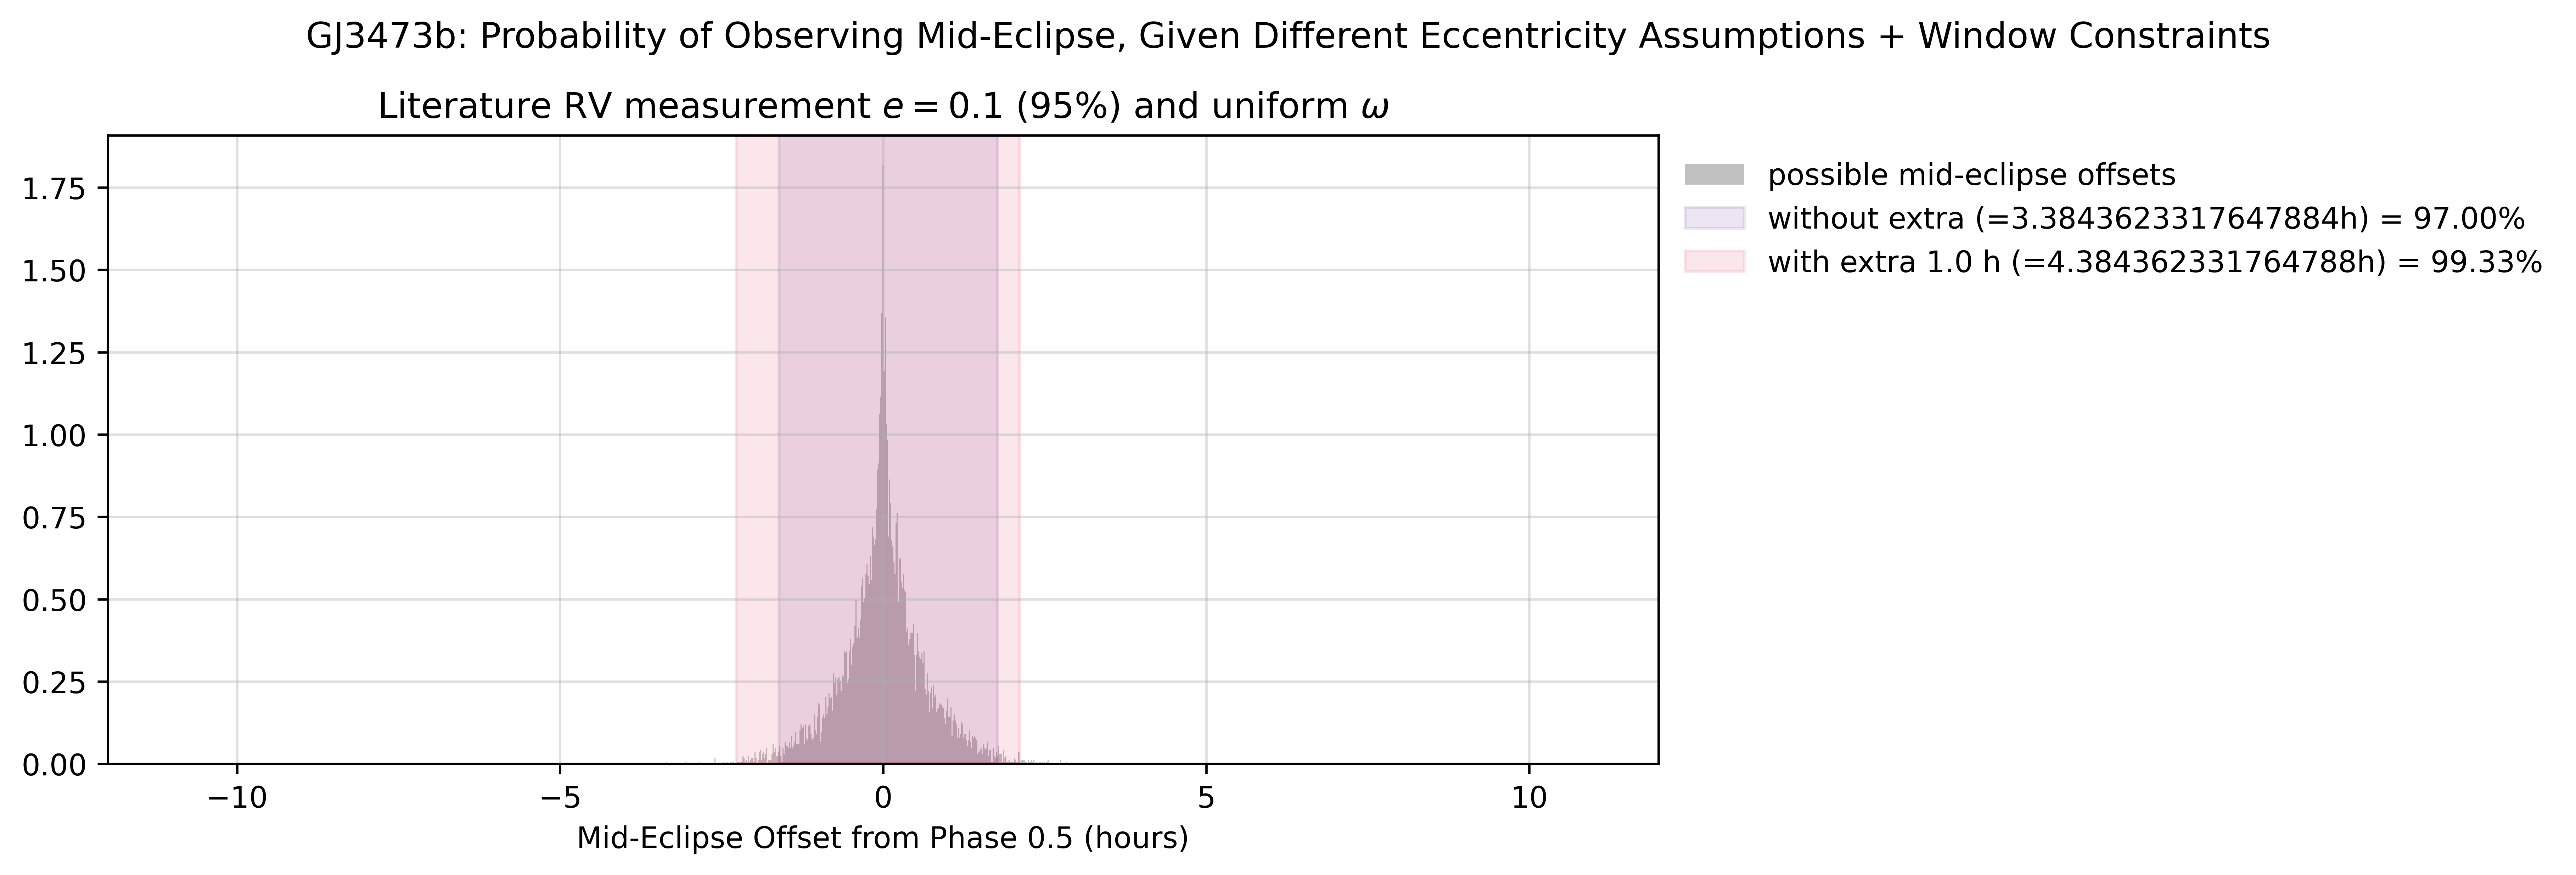

GJ 357 b P = 3.93060794716746 days ecc = 0.1
The uncertainty on predicted transit times in 2023 = 1.7077415210875222 minutes
event duration: 1.323550922208498 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 72.75%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 72.30% +/- 0.46%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
    

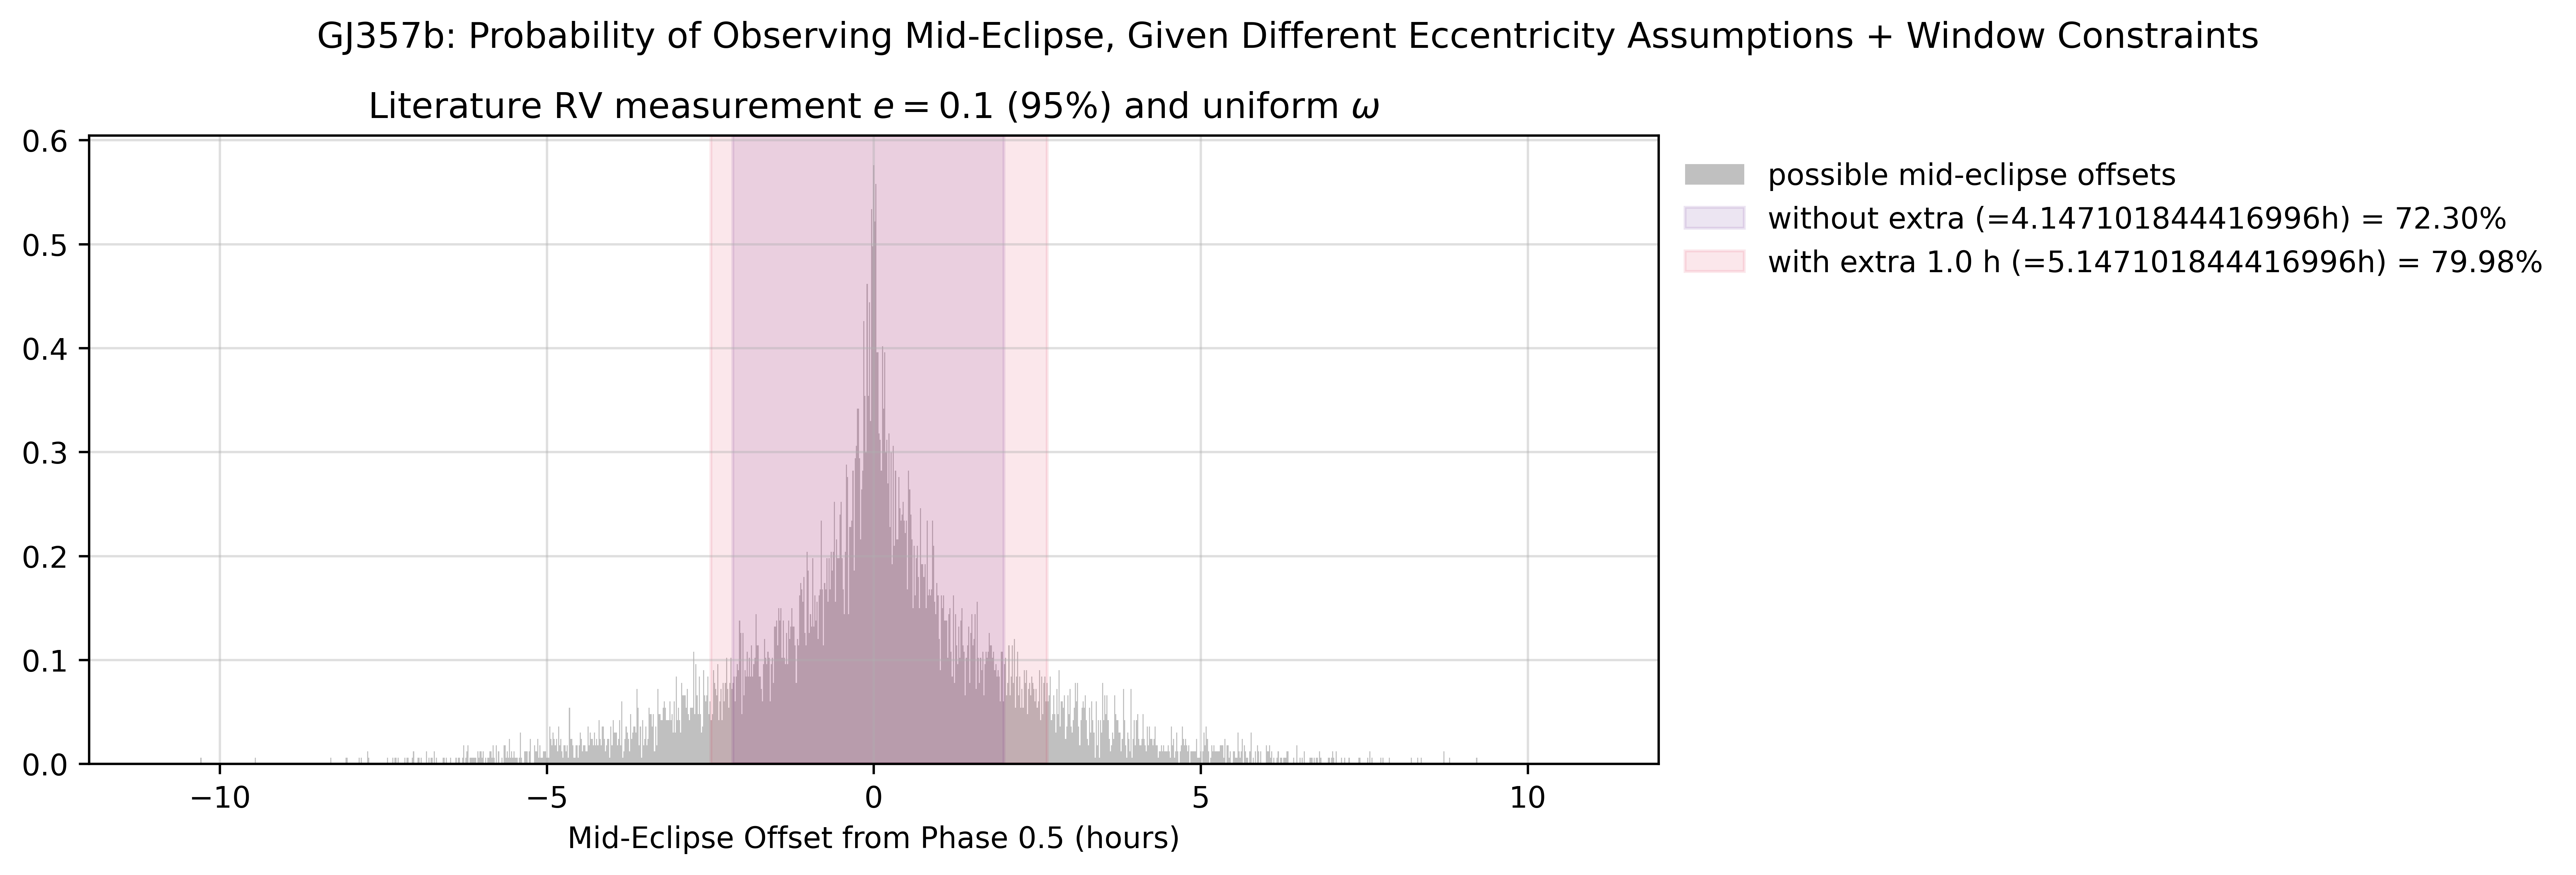

HD 260655 b P = 2.76953 days ecc = 0.039
The uncertainty on predicted transit times in 2023 = 12.221420811132392 minutes
event duration: 1.1532108714669438 h

                   With the assumption of ''Literature RV measurement $e=0.039$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 99.50%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.11% +/- 0.43%
                   

                   With the assumption of ''Literature RV measurement $e=0.039$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
   

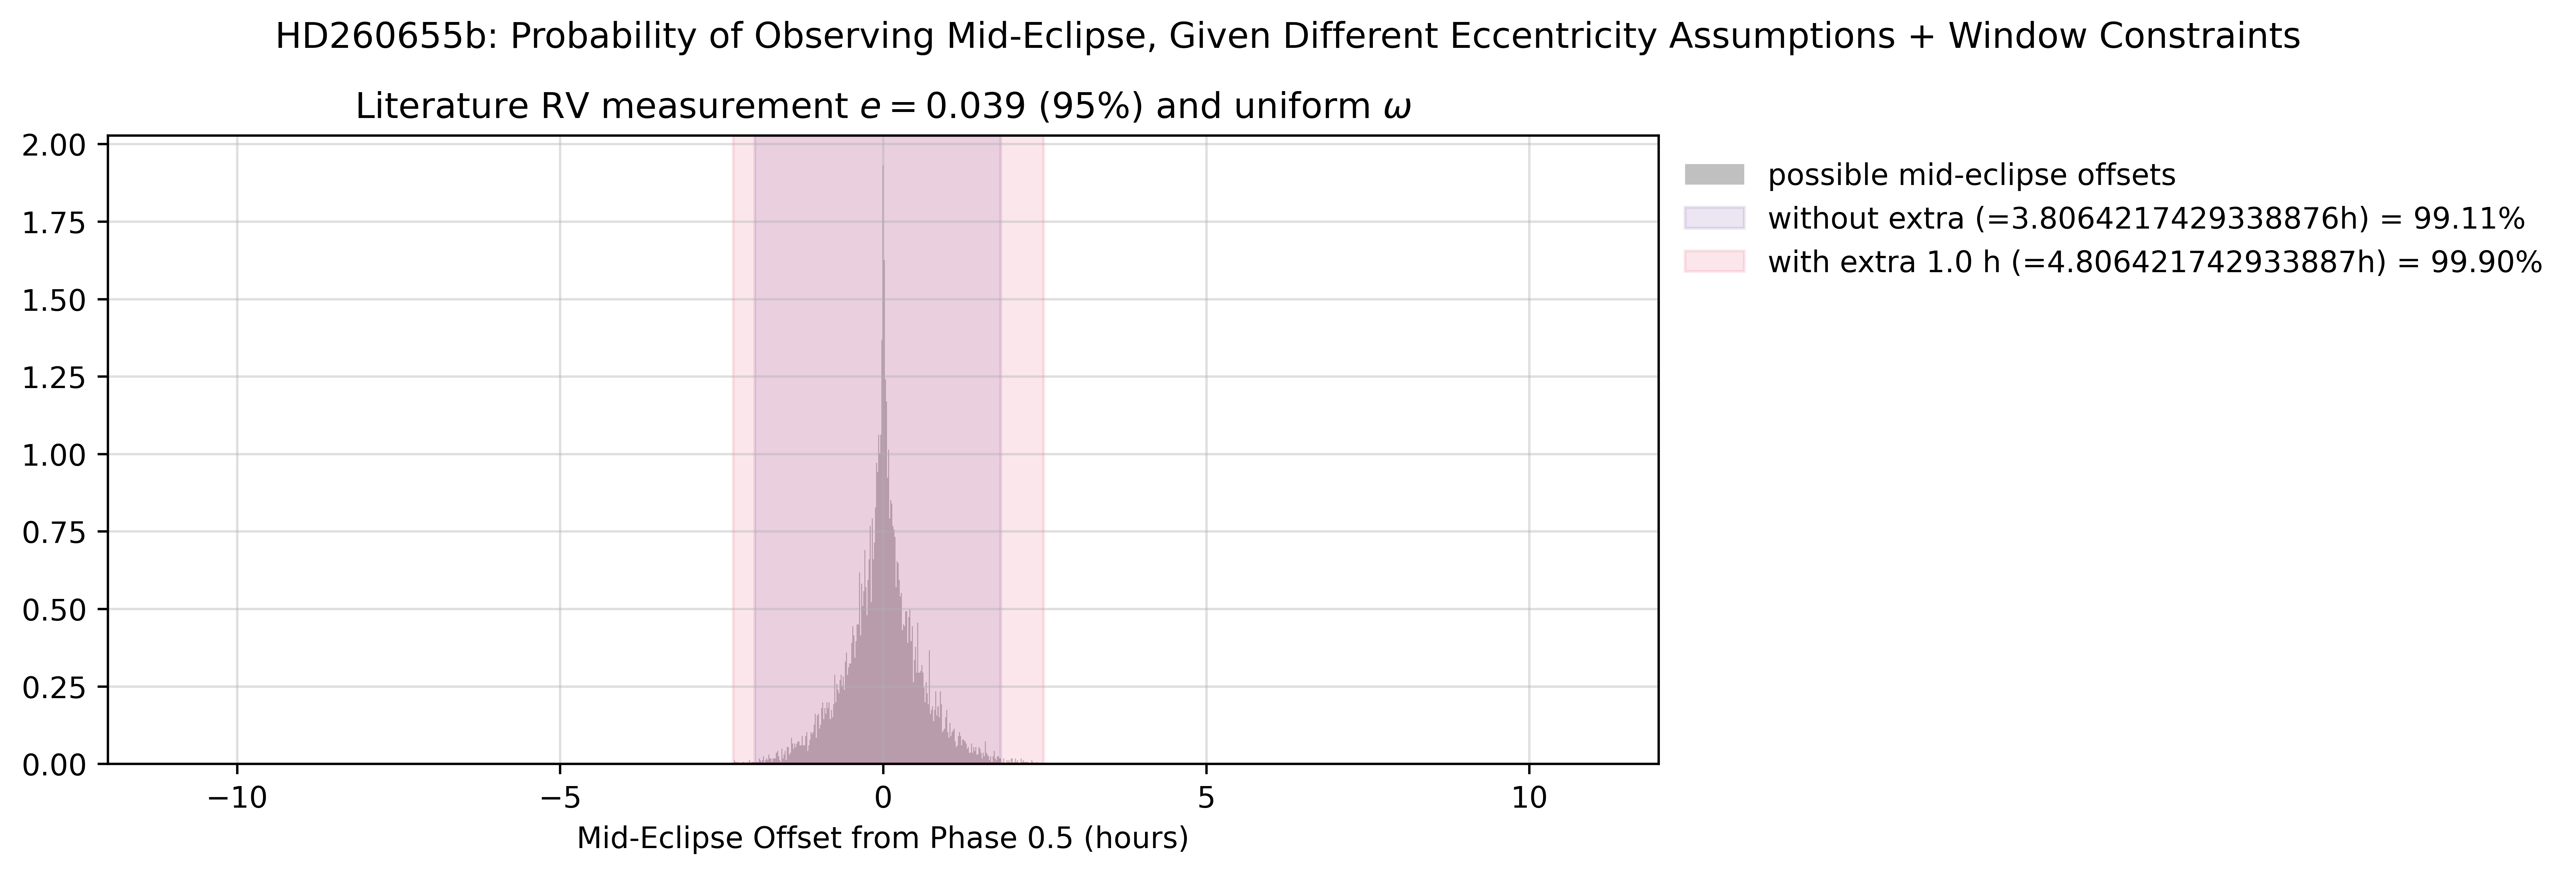

L 98-59 c P = 3.6906777 days ecc = 0.103
The uncertainty on predicted transit times in 2023 = 1.5744280757094706 minutes
event duration: 0.975153283961953 h

                   With the assumption of ''Literature RV measurement $e=0.103$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 66.87%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 66.42% +/- 0.34%
                   

                   With the assumption of ''Literature RV measurement $e=0.103$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
     

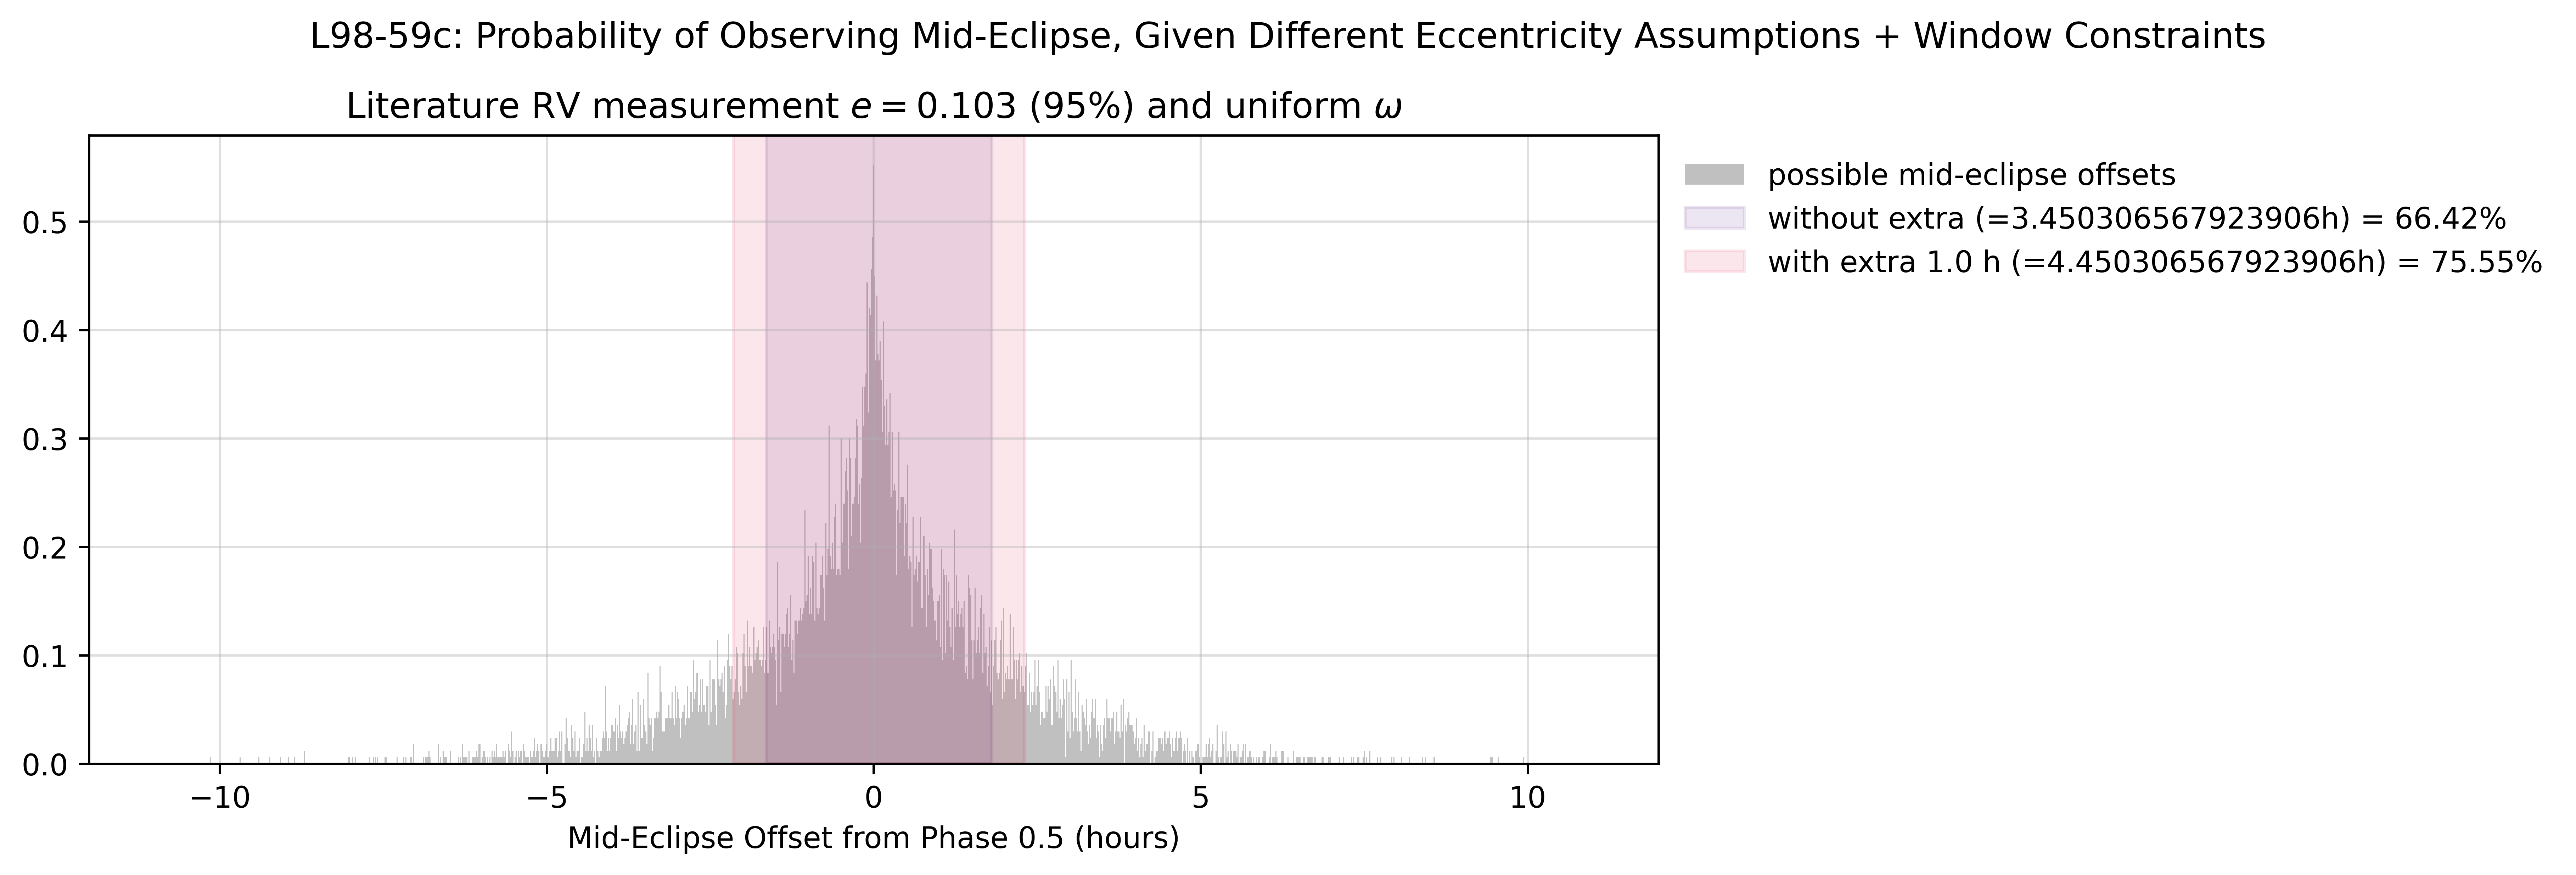

LHS 1140 c P = 3.777939728 days ecc = 0.1
The uncertainty on predicted transit times in 2023 = 4.312779264774647 minutes
event duration: 1.0829232789985161 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 70.15%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 69.60% +/- 0.57%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
       

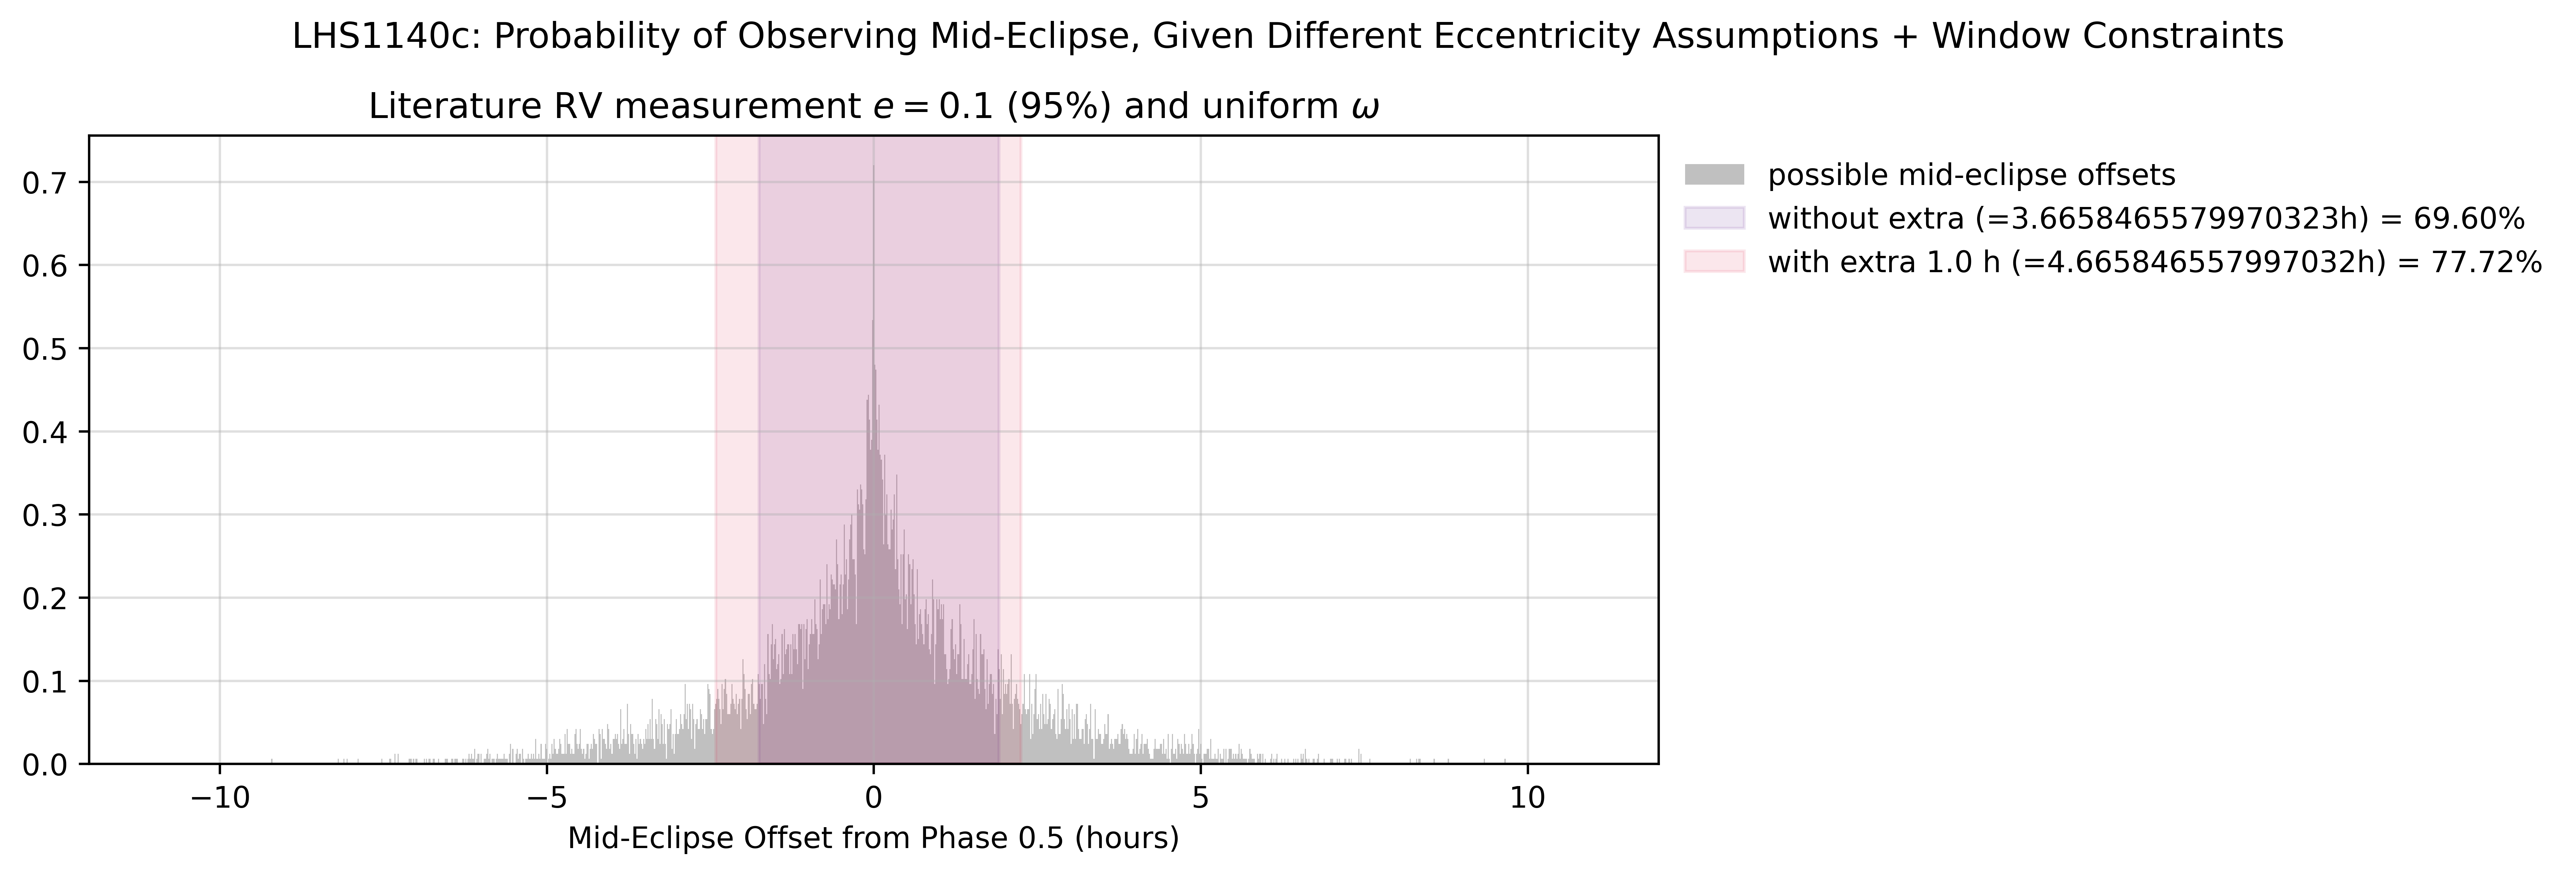

LHS 1478 b P = 1.9495378 days ecc = 0.1
The uncertainty on predicted transit times in 2023 = 4.487086626768008 minutes
event duration: 0.7230311073763287 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 84.68%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 83.41% +/- 1.20%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
          

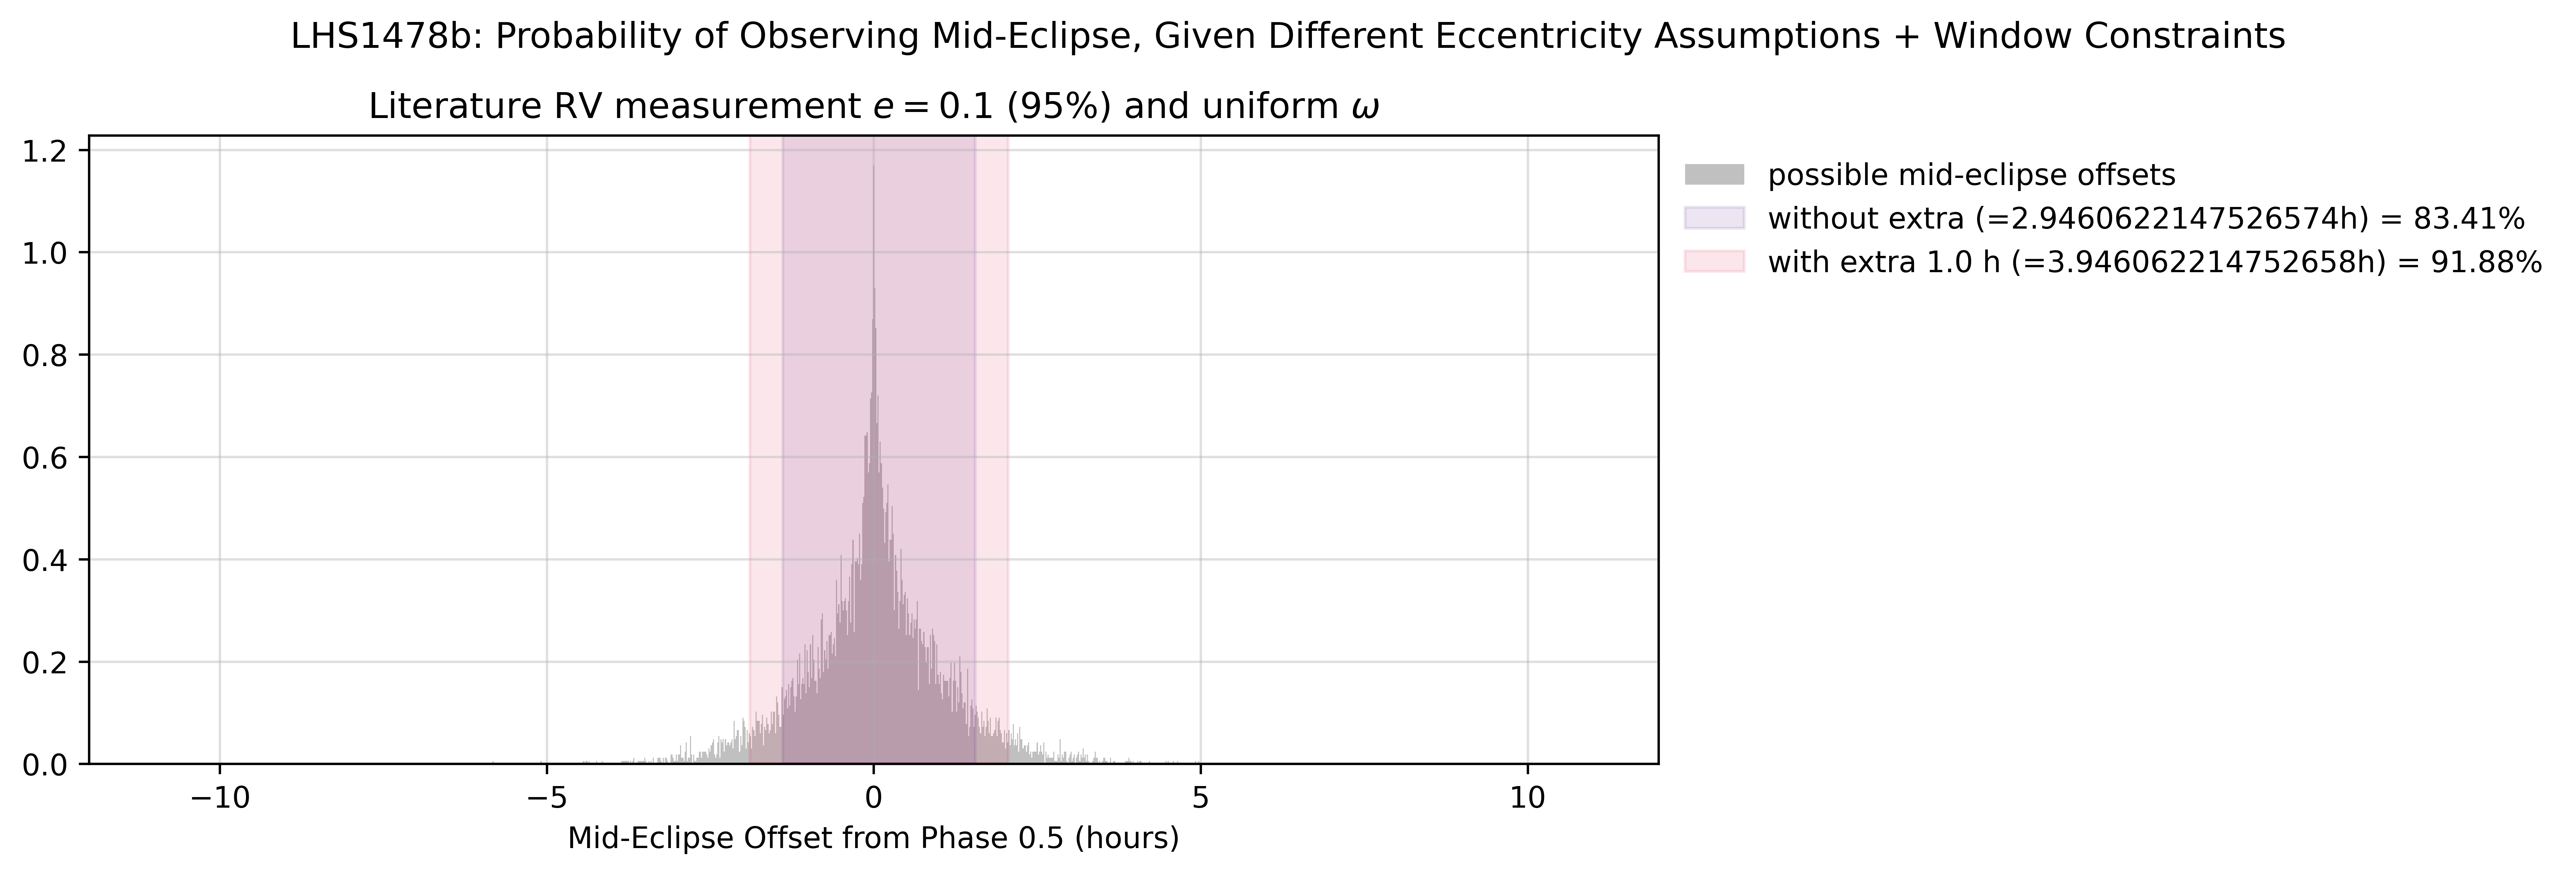

LTT 3780 b P = 0.768377 days ecc = 0.064
The uncertainty on predicted transit times in 2023 = 4.6233478804547365 minutes
event duration: 0.7628030950677402 h

                   With the assumption of ''Literature RV measurement $e=0.064$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is -0.41 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 100.00%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.74% +/- 0.45%
                   

                   With the assumption of ''Literature RV measurement $e=0.064$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.90 hours.
 

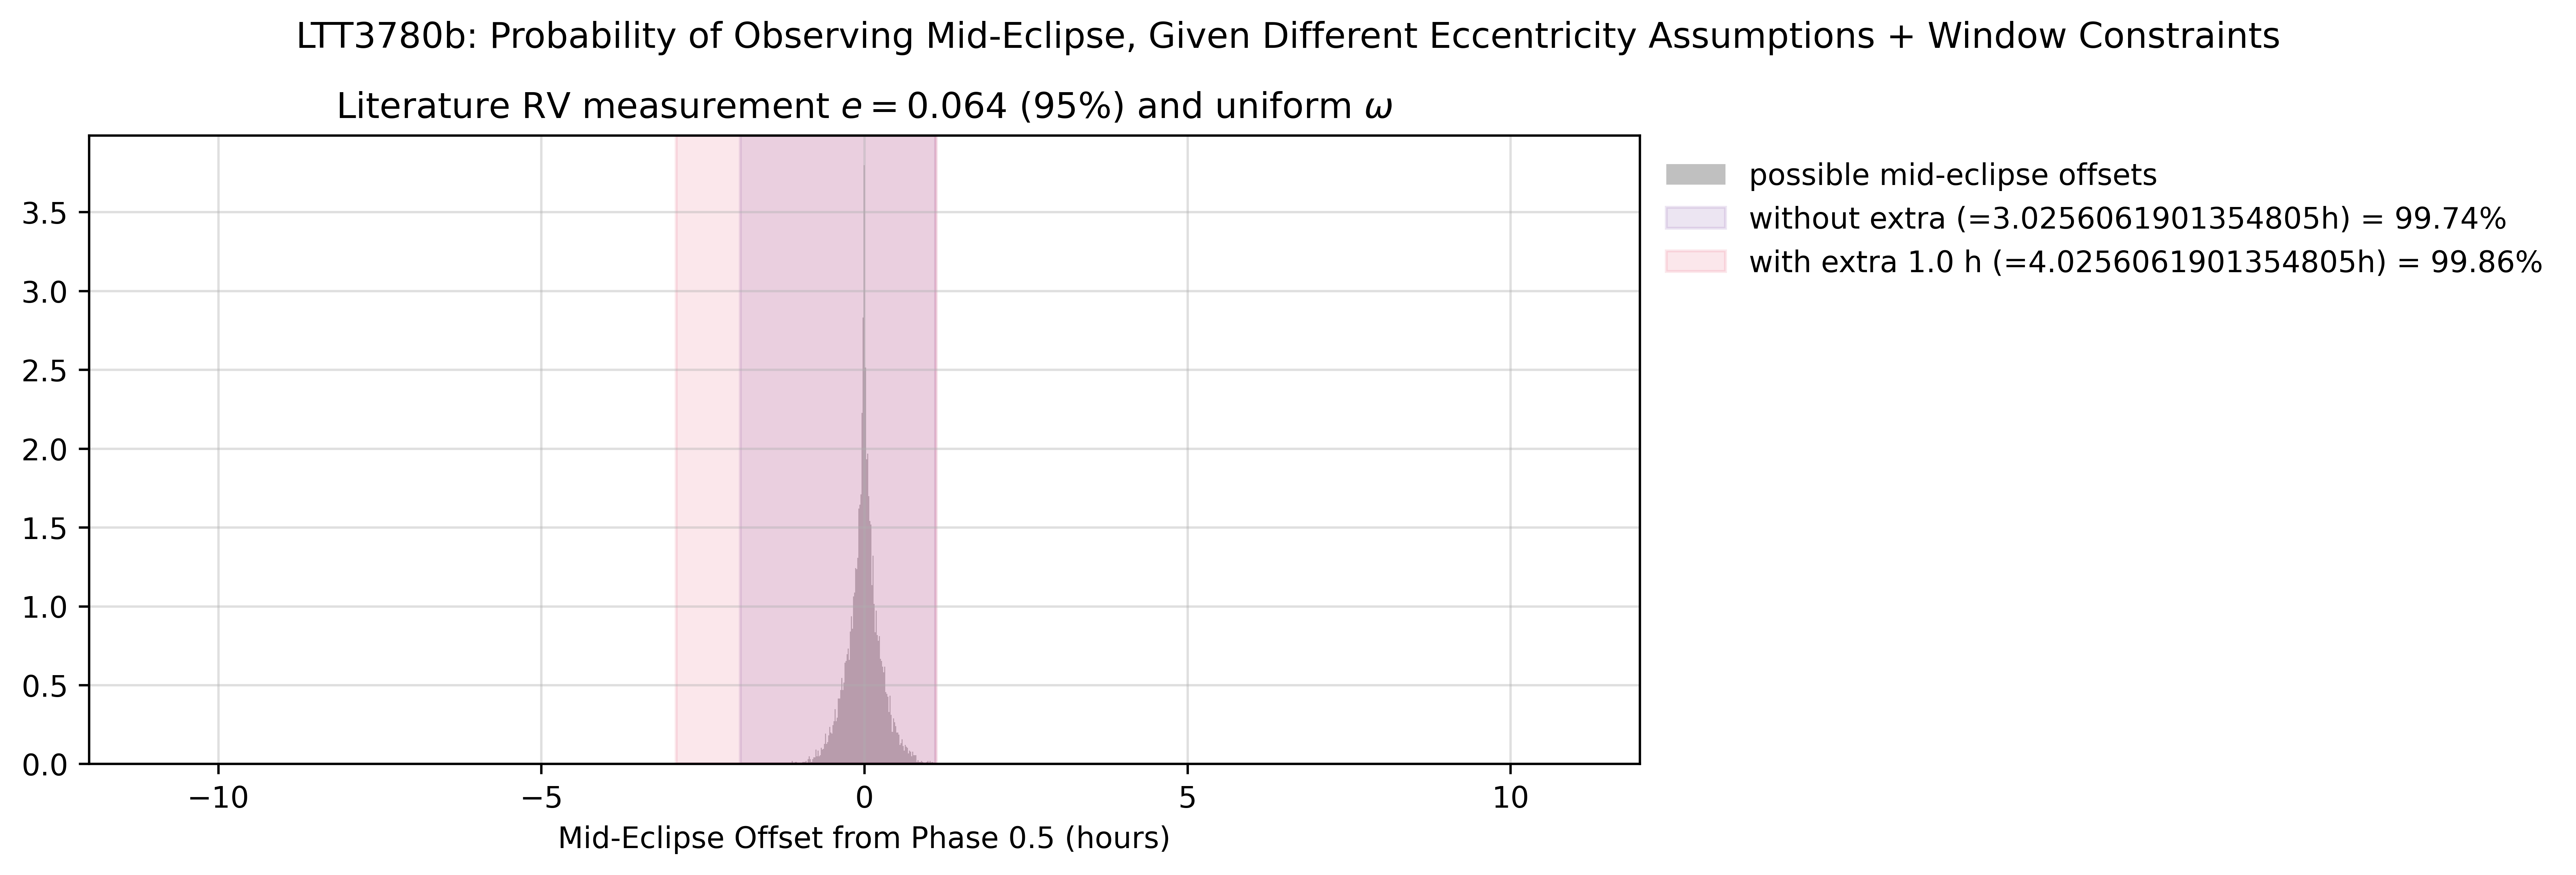

TOI-1468 b P = 1.8805136 days ecc = 0.1
The uncertainty on predicted transit times in 2023 = 3.031970042552479 minutes
event duration: 1.0513350608366205 h

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 90.98%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 90.34% +/- 0.61%
                   

                   With the assumption of ''Literature RV measurement $e=0.1$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is 0.08 hours.
         

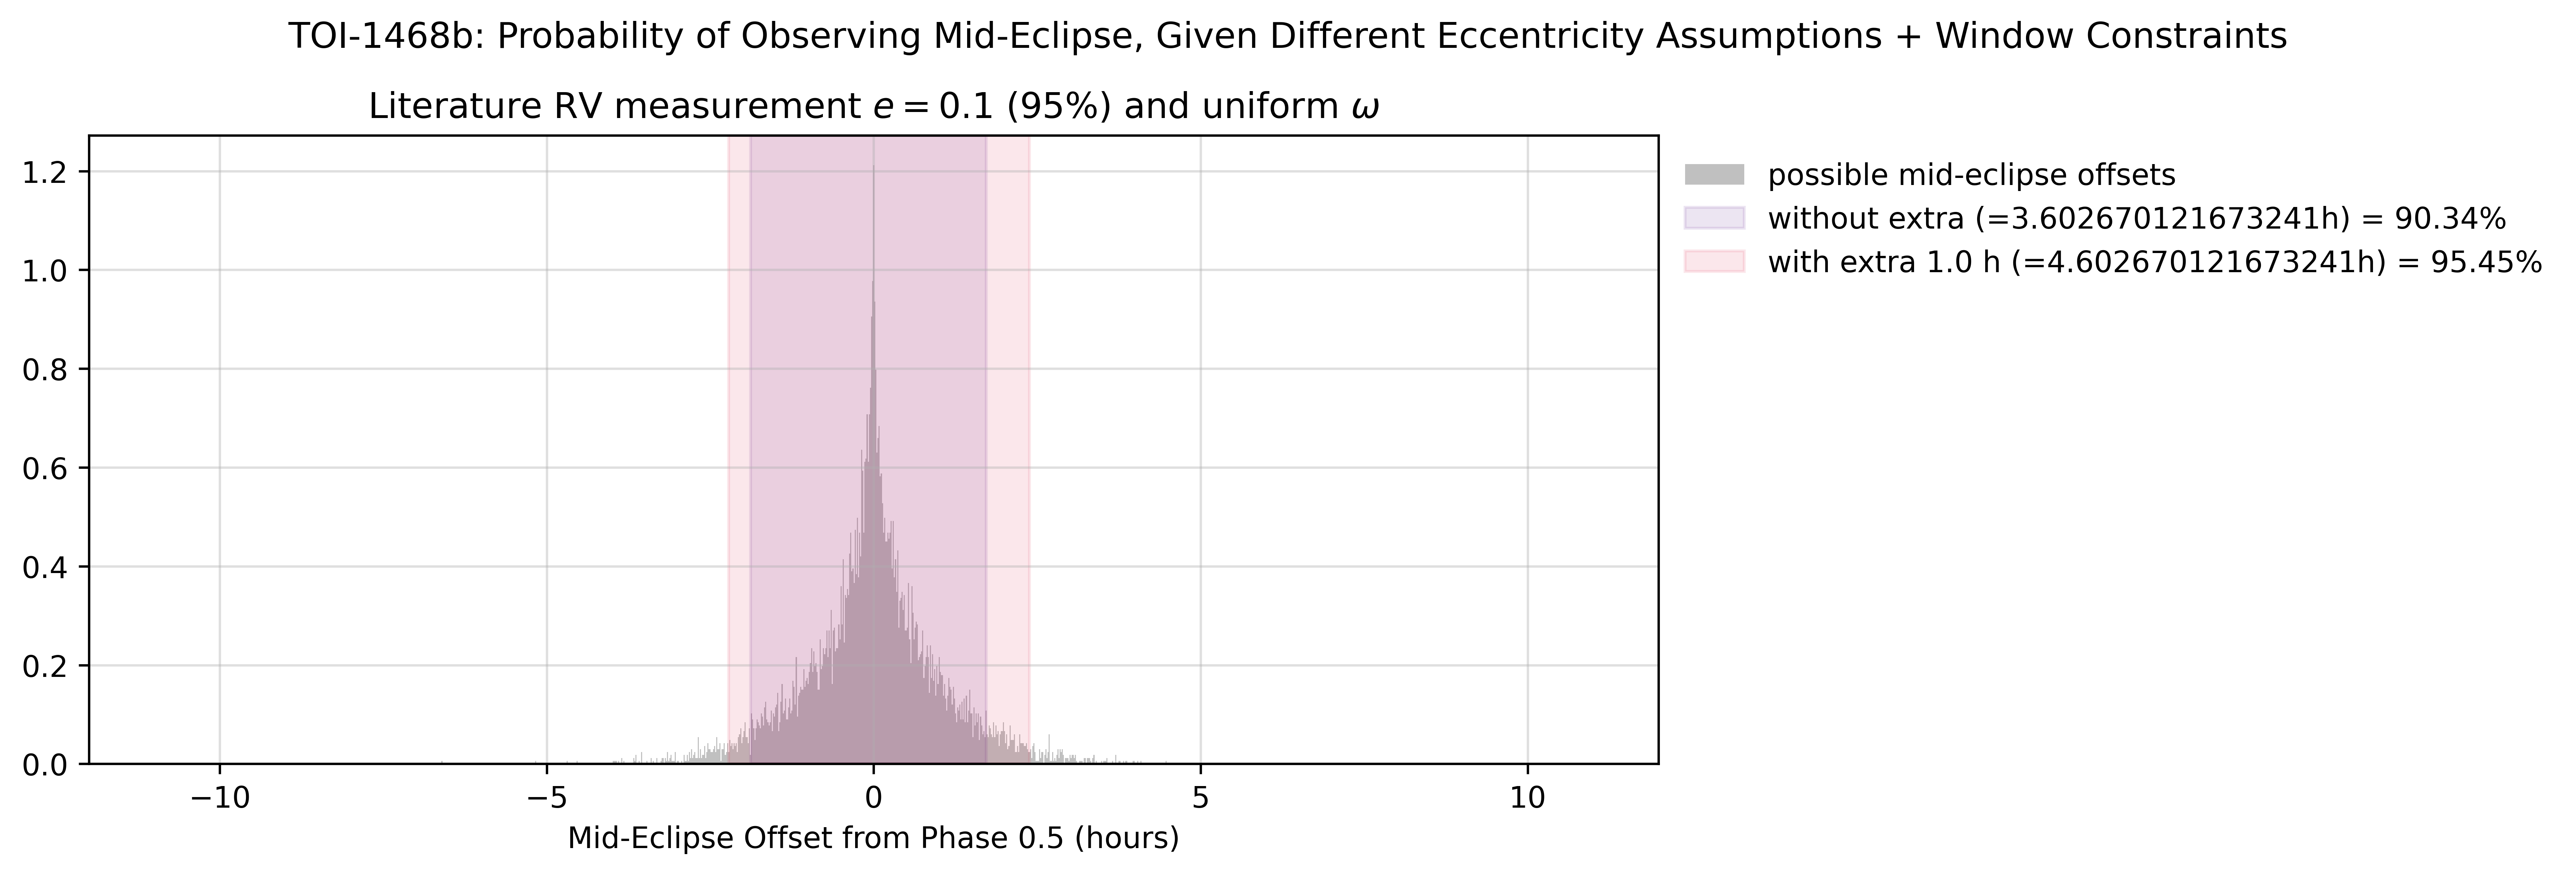

TOI-270 b P = 3.3601538 days ecc = 0.034
The uncertainty on predicted transit times in 2023 = 3.98915064988373 minutes
event duration: 1.4352326467008267 h

                   With the assumption of ''Literature RV measurement $e=0.034$ (95%) and uniform $\omega$', 
                   and the 'without extra' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
                   the mid-eclipse time should fall within the average post-settling  
                   observing window with a probability of 99.68%.
                   Averaged over allowed windows, the mid-eclipse should fall within 
                   this window with a probability of 99.45% +/- 0.21%
                   

                   With the assumption of ''Literature RV measurement $e=0.034$ (95%) and uniform $\omega$', 
                   and the 'with extra 1.0 h' observing window option, 
                   The best offset from exactly 0.5 phase is -0.08 hours.
    

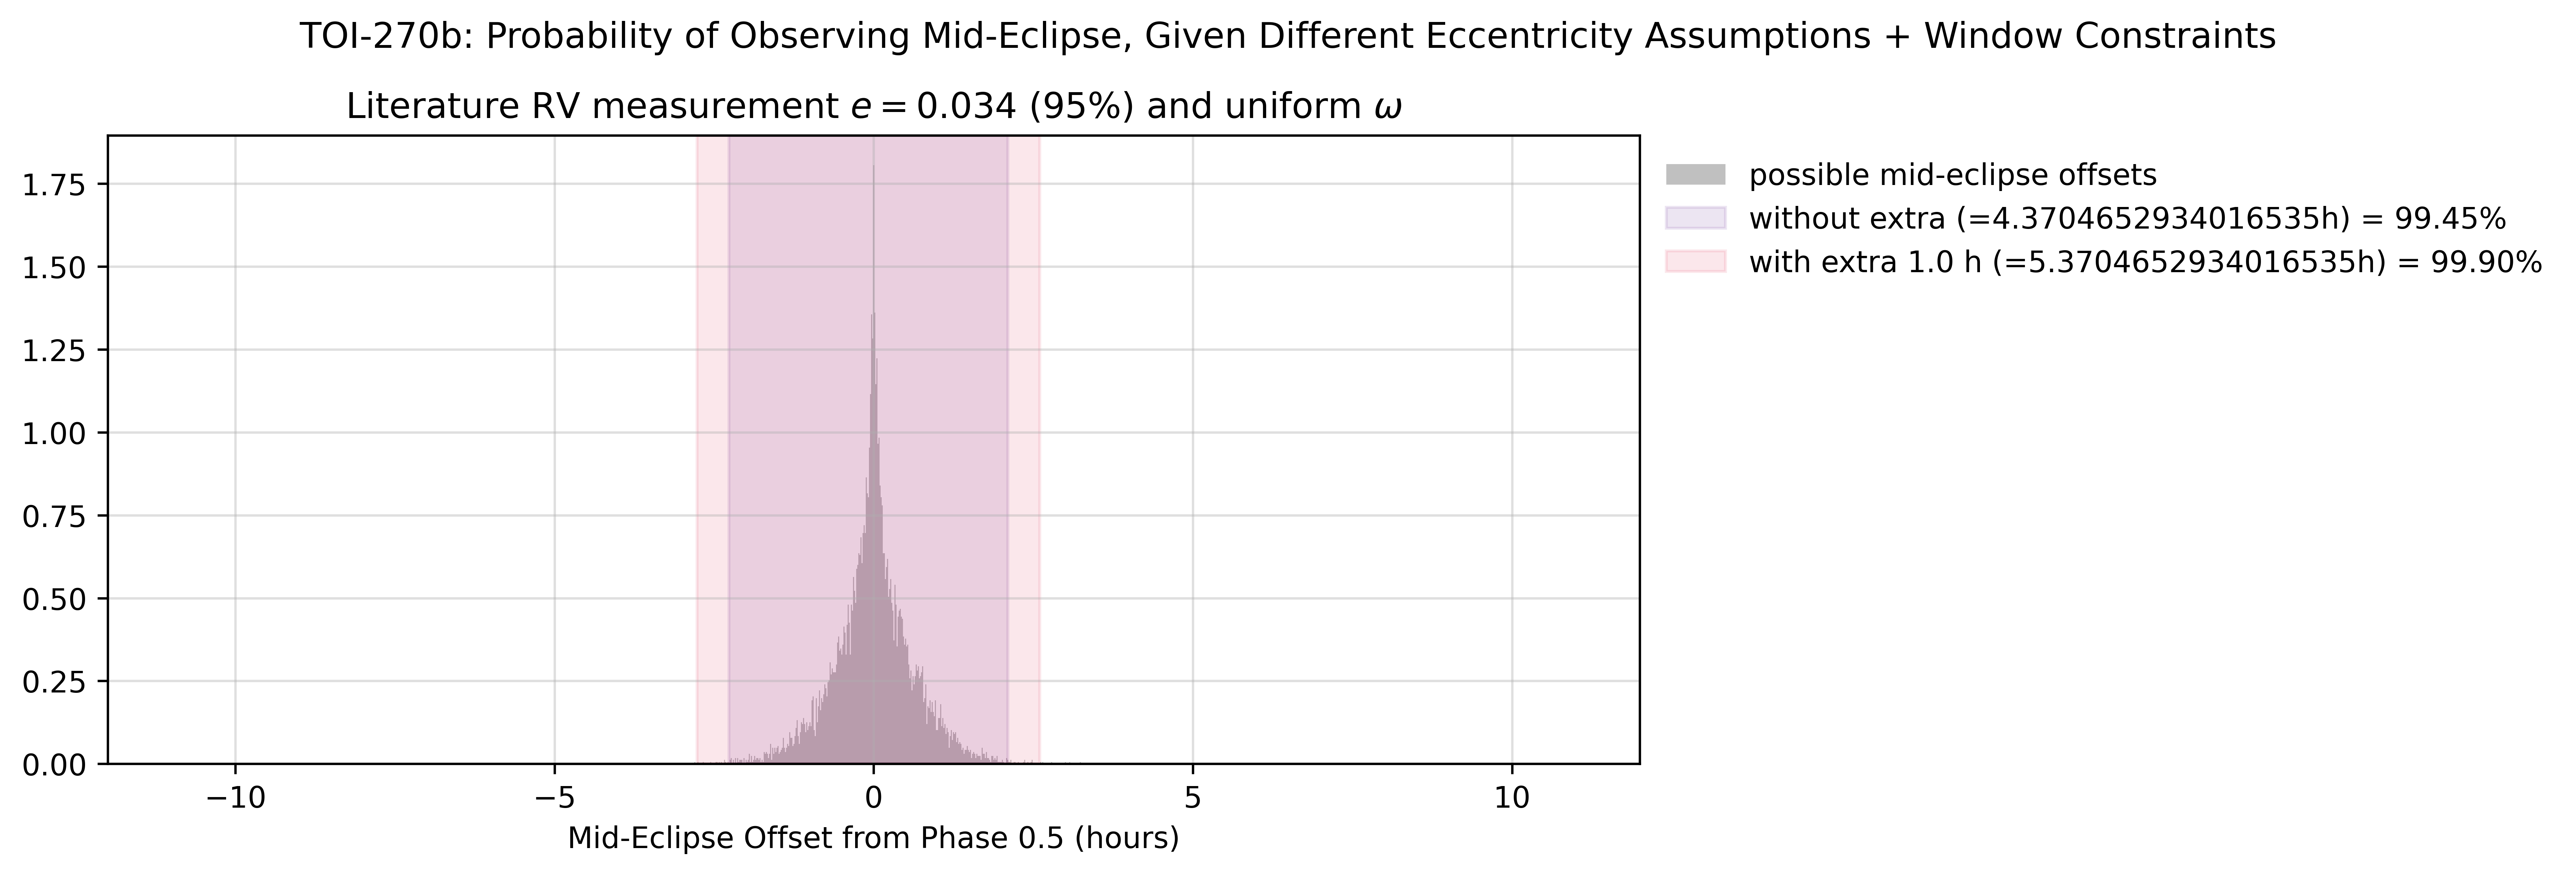

In [9]:
for targ in sample:
    if targ['pl_orbeccen'] == 0.0: targ['pl_orbeccen'] = 0.1
    print(targ['pl_name'], 'P =', targ['pl_orbper'], 'days', 'ecc =', targ['pl_orbeccen'])
    assumptions = calc_eclipse_timing(targ)
    windows = calc_window(targ, t_extra=1*u.hour)
    make_eclipse_timing_fig(targ['pl_name'].replace(" ", ""), assumptions, windows)

!! need to adjust based on skewed uncertainty in eccentricity; don't have distribution so need to measure one side, then the other... then make sure to add each to the correct side